In [1]:
%matplotlib inline

import dlc_practical_prologue as prologue
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import random
from models import FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX
import timeit

### _I - Setting up_

##### Loading data

In [2]:
def load():

    # Load the data
    size = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(size)

    #normalization
    #check https://stats.stackexchange.com/questions/174823/
    mu, std = train_input.mean(), train_input.std()
    train_input, test_input = train_input.sub(mu).div(std), test_input.sub(mu).div(std)

    #split the images
    train_input1, train_input2 = train_input[:, 0, :, :], train_input[:, 1, :, :] 
    test_input1, test_input2 = test_input[:, 0, :, :], test_input[:, 1, :, :] 

    #split the number pairs
    train_classes1, train_classes2 = train_classes[:, 0], train_classes[:, 1]
    test_classes1, test_classes2 = test_classes[:, 0], test_classes[:, 1]
    
    list = [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target]
    
    return list


In [3]:
 [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()

##### Batch generator

In [4]:
def data_generator(input1, input2, digits1, digits2, targets, batch_size):
    data_len = input1.size(0)
    i = 0
    while i < data_len:
        j = i + batch_size if i +batch_size < data_len else data_len
        yield input1[i:j], input2[i:j], \
              digits1[i:j],digits2[i:j],\
              targets[i:j]
        i = j
        

### _II - Defining the models_

In [5]:
"""
:param model_constructor: constructor for the model
:param optimizer_name: 'sgd' or 'adam'
:param lr: learning rate
:param batch_size: batch_size.
:return: an encapsulated model ready for the training
"""
def model_selector(model_constructor, optimizer_name, lr, batch_size, weight_decay=0, nb_epochs=25):
    
    model = dict()
    model['model'] = model_constructor()
    model['criterion'] = nn.CrossEntropyLoss()
    model['nb_epochs'] = nb_epochs
    model['batch_size'] = batch_size
    if(optimizer_name == 'sgd'):
        model['optimizer'] = torch.optim.SGD(model['model'].parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'adam':
        model['optimizer'] =  torch.optim.Adam(model['model'].parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    return model

In [14]:
def initialize_models():
    model_FNN = model_selector(FNN, 'adam', 0.011, 64, weight_decay = 0, nb_epochs = 100)
    model_FNN_WS = model_selector(FNN_WS, 'adam', 0.012 , 256, weight_decay = 0.01, nb_epochs=100)
    model_FNN_WS_AUX = model_selector(FNN_WS_AUX, 'adam', 0.01, 64, weight_decay = 0,nb_epochs=100 )
    model_FNN_AUX = model_selector(FNN_AUX, 'adam', 0.013 ,128, weight_decay = 0, nb_epochs = 100)

    model_CNN = model_selector(CNN, 'adam', 0.01, 64, weight_decay = 0.001, nb_epochs = 100)
    model_CNN_WS_AUX = model_selector(CNN_WS_AUX, 'adam', 0.009, 64, weight_decay = 0, nb_epochs = 100)
    model_CNN_WS = model_selector(CNN_WS, 'adam', 0.01, 64, weight_decay = 0.001, nb_epochs = 100)
    model_CNN_AUX = model_selector(CNN_AUX, 'adam', 0.013, 64, weight_decay = 0.001, nb_epochs = 100)
    
    models = [model_FNN, model_FNN_WS, model_FNN_AUX, model_FNN_WS_AUX, model_CNN, model_CNN_WS, model_CNN_AUX, model_CNN_WS_AUX]
    
    return models

### _III - Training the models_

##### Training and saving the histories

In [7]:
"""
:param model: a dict encapsulating the model and its properties
:param input1_tr: lhs of image pairs from training set
:param input2_tr: rhs of image pairs from training set
:param input1_te: lhs of image pairs from test set
:param input2_te: rhs of image pairs from test set
:param digits1_tr: classes of input1 from training set
:param digits2_tr: classes of input2 from training set
:param digits1_te: classes of input1 from test set
:param digits2_te: classes of input2 from test set
:param targets_tr: final boolean value indicating whether lhs <= rhs from training set
:param targets_te: final boolean value indicating whether lhs <= rhs from test set
:return: a dict encapsulating the model history
"""
def train(model, input1_tr, input2_tr, digits1_tr, digits2_tr, targets_tr, \
                 input1_te =None, input2_te =None, digits1_te=None, digits2_te=None, targets_te=None):
    
    epochs = model['nb_epochs']
    batch_size = model['batch_size']
    criterion = model['criterion']
    optimizer = model['optimizer']
    mdl = model['model']
      
    #  a dict to return whatever value we want to return
    #  e.g. loss at each epoch (useful for plotting)
    model_history = dict()
    
    
    train_loss_history = [] #a list to keep track of the losses at each epoch
    test_loss_history = []
    test_acc_history = []
    
    for e in range(epochs):
        
        epoch_train_loss = 0
        generator = data_generator(input1_tr, input2_tr, digits1_tr, digits2_tr, targets_tr, batch_size)
        for input1, input2, digits1, digits2, targets in generator:
            d1, d2, pred = mdl(input1, input2)   # run through the network
            pred_loss =  criterion(pred.view(-1, 2), targets) # loss due to boolean value
     
            if d1 is not None:
                pred_loss += criterion(d1.view(-1, 10), digits1)
                pred_loss += criterion(d2.view(-1, 10), digits2)
                pred_loss /= 3
                
            loss = pred_loss.item() #magnitude of the loss
            epoch_train_loss += loss
            mdl.zero_grad()         #reset the gradients for this epoch
            pred_loss.backward()    #calculate the gradients
            optimizer.step()        #update the weights
             
        train_loss_history.append(epoch_train_loss) #record the train loss 
        
        
        if input1_te is not None:
            epoch_test_loss = 0
            test_generator = data_generator(input1_te, input2_te, digits1_te, digits2_te, targets_te, batch_size)
            with torch.no_grad():
                for input1, input2, digits1, digits2, targets in test_generator:
                    d1, d2, pred = mdl(input1, input2)
                    pred_loss =  criterion(pred.view(-1, 2), targets)

                    if d1 is not None:
                        pred_loss += criterion(d1.view(-1, 10), digits1)
                        pred_loss += criterion(d2.view(-1, 10), digits2)
                        pred_loss /= 3

                    loss = pred_loss.item()
                    epoch_test_loss += loss

            test_loss_history.append(epoch_test_loss) #record the test loss
            
            acc_target, _, _= compute_nb_errors(mdl, input1_te, input2_te, digits1_te, digits2_te, targets_te)
            test_acc_history.append(acc_target)

        
        
        
    model_history['train_loss_history'] = train_loss_history
    model_history['test_loss_history'] = test_loss_history
    model_history['test_acc_history'] = test_acc_history
    return model_history

##### Computes the accuracy of the given model on the given data

In [8]:
"""
:param model: a dict encapsulating the model and its properties
:param input1: lhs of image pairs
:param input2: rhs of image pairs
:param digits1: classes of input1 
:param digits2: classes of input2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def compute_nb_errors(model, input1, input2, digits1, digits2, targets):
    n_samples = input1.shape[0]
    with torch.no_grad():
        d1,d2,pred = model(input1, input2)           # predict the digits + boolean
        _, indices = torch.max(pred.view(-1,2), 1) # torch.max returns the max value from the distribution and its corresponding index
        acc_target = (sum(indices == targets) / float(n_samples) * 100).item()  #calculate accuracy

        acc_d1, acc_d2 = 0, 0
        if d1 is not None: #the model returns digits if it makes use of aux loss. in this case we can report the accuracy of predicting the digits.
            _, indices1 = torch.max(d1.view(-1,10), 1)
            _, indices2 = torch.max(d2.view(-1,10), 1)
            acc_d1 += (sum(indices1 == digits1) / float(n_samples) * 100).item()
            acc_d2 += (sum(indices2 == digits2) / float(n_samples) * 100).item()


        return (acc_target, acc_d1, acc_d2)

  

##### _Cross-validation_

In [9]:
"""
:param input1: lhs of image pairs
:param input2: rhs of image pairs
:param digits1: classes of input1 
:param digits2: classes of input2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def cross_val_score(input1, input2, digits1, digits2, targets, model_constructor, optimizer_name, lr, batch_size, weight_decay,nb_epoch, k_folds=3):
    len_train = input1.shape[0]
    indices = list(range(len_train))
    random.seed(8)
    random.shuffle(indices)
    acc_target, acc_d1, acc_d2  = 0,0,0
    for k in range(k_folds):
        model = model_selector(model_constructor, optimizer_name, lr, batch_size, weight_decay, nb_epoch)  # init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        #train the model with k-1 training fold
        history = train(model, input1[train_indices], input2[train_indices], digits1[train_indices], digits2[train_indices], targets[train_indices])
        
        #compute the accuracy on 1 validation fold
        accs = compute_nb_errors(model['model'], input1[val_indices], input2[val_indices], digits1[val_indices], digits2[val_indices], targets[val_indices])
        
        acc_target += accs[0]
        acc_d1 += accs[1]
        acc_d2 += accs[2]
        #print('fold=', k, ' loss = ', history['loss_history'][-1])
    return (acc_target / k_folds, acc_d1 /k_folds, acc_d2 /k_folds)


### _IV - Hyper-parameter tuning_

##### Gird-search 

In [10]:
def grid_search():
    models = [FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX]
    epochs = [100]
    batch_sizes = [256, 128, 64]
    weight_decays = [0, 0.1, 0.01, 0.001]
    lrs = [0.001 * x for x in range(1, 15)]
    opts = ['adam']

    for m in models:
        best_batch, best_lr, best_opt, best_wd, best_epoch, best_acc = None, None, None, None,None,None
        for b in batch_sizes:
            for lr in lrs:
                for opt in opts:
                    for wd in weight_decays:
                        for e in epochs:
                            start = timeit.default_timer()
                            acc_t, acc_d1, acc_d2 = cross_val_score(train_input1, train_input2, train_classes1, train_classes2,  train_target, m, opt,lr,b,wd, e, k_folds=3)
                            end = timeit.default_timer()
                            print(m, b, e, wd, round(lr, 3), opt, '/// accuracies: ', acc_t, acc_d1, acc_d2, '/// time: ', round(end - start, 2))
                            if best_acc is None or acc_t > best_acc:
                                best_epoch, best_wd, best_batch, best_lr, best_opt, best_acc = e, wd, b, lr, opt, acc_t
        print('for model ', m, 'best accuracy is ', best_acc, 'at ', 'lr=', best_lr, 'b=', best_batch, 'opt=', best_opt, 'wd=', best_wd, 'epoch=', best_epoch)

In [180]:
grid_search()

<class 'models.FNN'> 256 100 0 0.001 adam /// accuracies:  69.80093892415364 0.0 0.0 /// time:  4.15
<class 'models.FNN'> 256 100 0.1 0.001 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  3.97
<class 'models.FNN'> 256 100 0.01 0.001 adam /// accuracies:  71.80264027913411 0.0 0.0 /// time:  3.64
<class 'models.FNN'> 256 100 0.001 0.001 adam /// accuracies:  72.09994506835938 0.0 0.0 /// time:  3.76
<class 'models.FNN'> 256 100 0 0.002 adam /// accuracies:  70.40033721923828 0.0 0.0 /// time:  3.71
<class 'models.FNN'> 256 100 0.1 0.002 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  3.57
<class 'models.FNN'> 256 100 0.01 0.002 adam /// accuracies:  70.39913940429688 0.0 0.0 /// time:  2.95
<class 'models.FNN'> 256 100 0.001 0.002 adam /// accuracies:  72.19944508870442 0.0 0.0 /// time:  3.23
<class 'models.FNN'> 256 100 0 0.003 adam /// accuracies:  70.49983978271484 0.0 0.0 /// time:  3.42
<class 'models.FNN'> 256 100 0.1 0.003 adam /// accuracies:  54.798811594

<class 'models.FNN'> 128 100 0 0.007 adam /// accuracies:  66.30013020833333 0.0 0.0 /// time:  7.36
<class 'models.FNN'> 128 100 0.1 0.007 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  8.53
<class 'models.FNN'> 128 100 0.01 0.007 adam /// accuracies:  64.09912872314453 0.0 0.0 /// time:  7.01
<class 'models.FNN'> 128 100 0.001 0.007 adam /// accuracies:  70.30293782552083 0.0 0.0 /// time:  6.47
<class 'models.FNN'> 128 100 0 0.008 adam /// accuracies:  67.69673665364583 0.0 0.0 /// time:  6.27
<class 'models.FNN'> 128 100 0.1 0.008 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  7.6
<class 'models.FNN'> 128 100 0.01 0.008 adam /// accuracies:  74.00034586588542 0.0 0.0 /// time:  7.19
<class 'models.FNN'> 128 100 0.001 0.008 adam /// accuracies:  73.90144856770833 0.0 0.0 /// time:  6.27
<class 'models.FNN'> 128 100 0 0.009 adam /// accuracies:  68.70193481445312 0.0 0.0 /// time:  5.66
<class 'models.FNN'> 128 100 0.1 0.009 adam /// accuracies:  54.7988115946

<class 'models.FNN'> 64 100 0 0.013 adam /// accuracies:  70.90353902180989 0.0 0.0 /// time:  10.39
<class 'models.FNN'> 64 100 0.1 0.013 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  11.32
<class 'models.FNN'> 64 100 0.01 0.013 adam /// accuracies:  68.10103607177734 0.0 0.0 /// time:  9.61
<class 'models.FNN'> 64 100 0.001 0.013 adam /// accuracies:  72.50064595540364 0.0 0.0 /// time:  9.85
<class 'models.FNN'> 64 100 0 0.014 adam /// accuracies:  63.307318369547524 0.0 0.0 /// time:  10.42
<class 'models.FNN'> 64 100 0.1 0.014 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  10.1
<class 'models.FNN'> 64 100 0.01 0.014 adam /// accuracies:  67.59813690185547 0.0 0.0 /// time:  11.14
<class 'models.FNN'> 64 100 0.001 0.014 adam /// accuracies:  73.8978500366211 0.0 0.0 /// time:  9.16
for model  <class 'models.FNN'> best accuracy is  75.49915313720703 at  lr= 0.011 b= 64 opt= adam wd= 0 epoch= 100
<class 'models.FNN_WS'> 256 100 0 0.001 adam /// accuracies:  7

<class 'models.FNN_WS'> 128 100 0.1 0.004 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  6.67
<class 'models.FNN_WS'> 128 100 0.01 0.004 adam /// accuracies:  77.50145467122395 0.0 0.0 /// time:  5.97
<class 'models.FNN_WS'> 128 100 0.001 0.004 adam /// accuracies:  71.40074157714844 0.0 0.0 /// time:  6.44
<class 'models.FNN_WS'> 128 100 0 0.005 adam /// accuracies:  70.80133819580078 0.0 0.0 /// time:  6.29
<class 'models.FNN_WS'> 128 100 0.1 0.005 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  6.64
<class 'models.FNN_WS'> 128 100 0.01 0.005 adam /// accuracies:  78.39756266276042 0.0 0.0 /// time:  6.2
<class 'models.FNN_WS'> 128 100 0.001 0.005 adam /// accuracies:  74.99774932861328 0.0 0.0 /// time:  6.37
<class 'models.FNN_WS'> 128 100 0 0.006 adam /// accuracies:  71.60124206542969 0.0 0.0 /// time:  6.13
<class 'models.FNN_WS'> 128 100 0.1 0.006 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  6.65
<class 'models.FNN_WS'> 128 100 0.01 0.006 ad

<class 'models.FNN_WS'> 64 100 0.001 0.009 adam /// accuracies:  75.49885559082031 0.0 0.0 /// time:  8.36
<class 'models.FNN_WS'> 64 100 0 0.01 adam /// accuracies:  75.3031514485677 0.0 0.0 /// time:  8.2
<class 'models.FNN_WS'> 64 100 0.1 0.01 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  10.05
<class 'models.FNN_WS'> 64 100 0.01 0.01 adam /// accuracies:  77.7987569173177 0.0 0.0 /// time:  8.35
<class 'models.FNN_WS'> 64 100 0.001 0.01 adam /// accuracies:  76.20015207926433 0.0 0.0 /// time:  7.41
<class 'models.FNN_WS'> 64 100 0 0.011 adam /// accuracies:  75.29805246988933 0.0 0.0 /// time:  7.84
<class 'models.FNN_WS'> 64 100 0.1 0.011 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  8.93
<class 'models.FNN_WS'> 64 100 0.01 0.011 adam /// accuracies:  75.79945373535156 0.0 0.0 /// time:  7.99
<class 'models.FNN_WS'> 64 100 0.001 0.011 adam /// accuracies:  75.80005391438802 0.0 0.0 /// time:  7.94
<class 'models.FNN_WS'> 64 100 0 0.012 adam /// accuracie

<class 'models.FNN_WS_AUX'> 256 100 0.001 0.011 adam /// accuracies:  94.59908548990886 91.39888509114583 92.29978434244792 /// time:  4.22
<class 'models.FNN_WS_AUX'> 256 100 0 0.012 adam /// accuracies:  93.39908599853516 90.59928385416667 91.00148010253906 /// time:  4.27
<class 'models.FNN_WS_AUX'> 256 100 0.1 0.012 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  4.35
<class 'models.FNN_WS_AUX'> 256 100 0.01 0.012 adam /// accuracies:  92.79968770345052 89.80058034261067 89.10077667236328 /// time:  3.99
<class 'models.FNN_WS_AUX'> 256 100 0.001 0.012 adam /// accuracies:  95.09868876139323 91.99888610839844 92.20028432210286 /// time:  4.21
<class 'models.FNN_WS_AUX'> 256 100 0 0.013 adam /// accuracies:  93.59868876139323 91.0985844930013 90.30107879638672 /// time:  4.32
<class 'models.FNN_WS_AUX'> 256 100 0.1 0.013 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  4.38
<class 'models.FNN_WS_AUX'> 256 

<class 'models.FNN_WS_AUX'> 128 100 0.001 0.012 adam /// accuracies:  94.69888814290364 92.3983866373698 90.30017852783203 /// time:  6.99
<class 'models.FNN_WS_AUX'> 128 100 0 0.013 adam /// accuracies:  93.7994867960612 91.59938303629558 91.00268046061198 /// time:  6.96
<class 'models.FNN_WS_AUX'> 128 100 0.1 0.013 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  6.98
<class 'models.FNN_WS_AUX'> 128 100 0.01 0.013 adam /// accuracies:  91.60058085123698 88.80047861735027 88.00027720133464 /// time:  6.85
<class 'models.FNN_WS_AUX'> 128 100 0.001 0.013 adam /// accuracies:  93.9996846516927 91.70038096110027 91.30058034261067 /// time:  6.94
<class 'models.FNN_WS_AUX'> 128 100 0 0.014 adam /// accuracies:  94.09888712565105 91.19808705647786 91.50108083089192 /// time:  6.93
<class 'models.FNN_WS_AUX'> 128 100 0.1 0.014 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  6.95
<class 'models.FNN_WS_AUX'> 128 10

<class 'models.FNN_WS_AUX'> 64 100 0.001 0.013 adam /// accuracies:  93.49888865152995 90.59898376464844 91.50108083089192 /// time:  9.26
<class 'models.FNN_WS_AUX'> 64 100 0 0.014 adam /// accuracies:  94.29998270670573 91.10008239746094 91.60028330485027 /// time:  10.01
<class 'models.FNN_WS_AUX'> 64 100 0.1 0.014 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  9.67
<class 'models.FNN_WS_AUX'> 64 100 0.01 0.014 adam /// accuracies:  92.1996841430664 87.99967702229817 88.00057729085286 /// time:  9.45
<class 'models.FNN_WS_AUX'> 64 100 0.001 0.014 adam /// accuracies:  94.89968617757161 91.49988301595052 91.80227915445964 /// time:  9.21
for model  <class 'models.FNN_WS_AUX'> best accuracy is  95.39959208170573 at  lr= 0.01 b= 64 opt= adam wd= 0 epoch= 100
<class 'models.FNN_AUX'> 256 100 0 0.001 adam /// accuracies:  91.79898579915364 88.09947713216145 87.69937896728516 /// time:  4.35
<class 'models.FNN_AUX'> 256 100 0.1 0.001 adam /// accur

<class 'models.FNN_AUX'> 256 100 0.001 0.014 adam /// accuracies:  91.59848531087239 87.8989766438802 87.1988754272461 /// time:  4.91
<class 'models.FNN_AUX'> 128 100 0 0.001 adam /// accuracies:  91.89938354492188 87.99967702229817 88.49927775065105 /// time:  7.36
<class 'models.FNN_AUX'> 128 100 0.1 0.001 adam /// accuracies:  53.09710947672526 9.999820073445639 9.299719174702963 /// time:  7.98
<class 'models.FNN_AUX'> 128 100 0.01 0.001 adam /// accuracies:  81.099365234375 72.59894561767578 72.50903574625652 /// time:  7.07
<class 'models.FNN_AUX'> 128 100 0.001 0.001 adam /// accuracies:  90.9996821085612 87.99937693277995 87.60047403971355 /// time:  7.02
<class 'models.FNN_AUX'> 128 100 0 0.002 adam /// accuracies:  92.09958394368489 88.60027821858723 88.09947967529297 /// time:  7.11
<class 'models.FNN_AUX'> 128 100 0.1 0.002 adam /// accuracies:  53.09710947672526 9.999820073445639 9.299719174702963 /// time:  7.98
<class 'models.FNN_AUX'> 128 100 0.01 0.002 adam /// accura

<class 'models.FNN_AUX'> 64 100 0 0.002 adam /// accuracies:  92.69958750406902 88.50047810872395 87.80007425944011 /// time:  10.31
<class 'models.FNN_AUX'> 64 100 0.1 0.002 adam /// accuracies:  53.09710947672526 9.999820073445639 9.700119654337565 /// time:  12.05
<class 'models.FNN_AUX'> 64 100 0.01 0.002 adam /// accuracies:  82.89787038167317 78.49166488647461 72.80334218343098 /// time:  10.43
<class 'models.FNN_AUX'> 64 100 0.001 0.002 adam /// accuracies:  92.29858652750652 89.29917907714844 88.59938049316406 /// time:  10.53
<class 'models.FNN_AUX'> 64 100 0 0.003 adam /// accuracies:  92.49878692626953 89.19937896728516 88.69917805989583 /// time:  10.64
<class 'models.FNN_AUX'> 64 100 0.1 0.003 adam /// accuracies:  53.09710947672526 9.999820073445639 9.299719174702963 /// time:  11.64
<class 'models.FNN_AUX'> 64 100 0.01 0.003 adam /// accuracies:  83.50176493326823 75.50035095214844 74.60544077555339 /// time:  10.52
<class 'models.FNN_AUX'> 64 100 0.001 0.003 adam /// ac

<class 'models.CNN'> 256 100 0.001 0.003 adam /// accuracies:  73.20014953613281 0.0 0.0 /// time:  71.0
<class 'models.CNN'> 256 100 0 0.004 adam /// accuracies:  71.89974466959636 0.0 0.0 /// time:  71.0
<class 'models.CNN'> 256 100 0.1 0.004 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  70.98
<class 'models.CNN'> 256 100 0.01 0.004 adam /// accuracies:  59.40341567993164 0.0 0.0 /// time:  71.03
<class 'models.CNN'> 256 100 0.001 0.004 adam /// accuracies:  74.3012466430664 0.0 0.0 /// time:  71.3
<class 'models.CNN'> 256 100 0 0.005 adam /// accuracies:  71.20294189453125 0.0 0.0 /// time:  70.81
<class 'models.CNN'> 256 100 0.1 0.005 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  70.64
<class 'models.CNN'> 256 100 0.01 0.005 adam /// accuracies:  59.30331802368164 0.0 0.0 /// time:  70.64
<class 'models.CNN'> 256 100 0.001 0.005 adam /// accuracies:  71.80384063720703 0.0 0.0 /// time:  70.97
<class 'models.CNN'> 256 100 0 0.006 adam /// accuracies:  70.40

<class 'models.CNN'> 128 100 0.01 0.009 adam /// accuracies:  57.70171229044596 0.0 0.0 /// time:  84.5
<class 'models.CNN'> 128 100 0.001 0.009 adam /// accuracies:  70.300537109375 0.0 0.0 /// time:  80.83
<class 'models.CNN'> 128 100 0 0.01 adam /// accuracies:  69.30163828531902 0.0 0.0 /// time:  80.08
<class 'models.CNN'> 128 100 0.1 0.01 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  81.37
<class 'models.CNN'> 128 100 0.01 0.01 adam /// accuracies:  59.80381647745768 0.0 0.0 /// time:  83.4
<class 'models.CNN'> 128 100 0.001 0.01 adam /// accuracies:  71.30213928222656 0.0 0.0 /// time:  76.53
<class 'models.CNN'> 128 100 0 0.011 adam /// accuracies:  72.00074259440105 0.0 0.0 /// time:  76.6
<class 'models.CNN'> 128 100 0.1 0.011 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  79.19
<class 'models.CNN'> 128 100 0.01 0.011 adam /// accuracies:  59.20321782430013 0.0 0.0 /// time:  81.79
<class 'models.CNN'> 128 100 0.001 0.011 adam /// accuracies:  71.1019

<class 'models.CNN_WS_AUX'> 256 100 0.1 0.001 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  70.45
<class 'models.CNN_WS_AUX'> 256 100 0.01 0.001 adam /// accuracies:  94.29789225260417 90.79588572184245 91.29608662923177 /// time:  70.12
<class 'models.CNN_WS_AUX'> 256 100 0.001 0.001 adam /// accuracies:  94.10428619384766 92.10498046875 91.60657755533855 /// time:  70.25
<class 'models.CNN_WS_AUX'> 256 100 0 0.002 adam /// accuracies:  91.60208129882812 88.20047251383464 89.40377553304036 /// time:  70.27
<class 'models.CNN_WS_AUX'> 256 100 0.1 0.002 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  70.6
<class 'models.CNN_WS_AUX'> 256 100 0.01 0.002 adam /// accuracies:  95.90069325764973 94.60028839111328 94.50018819173177 /// time:  69.83
<class 'models.CNN_WS_AUX'> 256 100 0.001 0.002 adam /// accuracies:  97.19959513346355 95.9012934366862 95.49998982747395 /// time:  70.36
<class 'models.CNN_WS_AUX'

<class 'models.CNN_WS_AUX'> 128 100 0 0.002 adam /// accuracies:  86.60696665445964 82.31165059407552 82.21694691975911 /// time:  77.32
<class 'models.CNN_WS_AUX'> 128 100 0.1 0.002 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  78.1
<class 'models.CNN_WS_AUX'> 128 100 0.01 0.002 adam /// accuracies:  96.39999643961589 94.79959106445312 95.20029195149739 /// time:  76.32
<class 'models.CNN_WS_AUX'> 128 100 0.001 0.002 adam /// accuracies:  96.29929606119792 95.49968973795573 95.19878896077473 /// time:  75.71
<class 'models.CNN_WS_AUX'> 128 100 0 0.003 adam /// accuracies:  96.59869639078777 95.49879201253255 96.09909566243489 /// time:  75.75
<class 'models.CNN_WS_AUX'> 128 100 0.1 0.003 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  75.3
<class 'models.CNN_WS_AUX'> 128 100 0.01 0.003 adam /// accuracies:  96.69969685872395 94.89909108479817 95.09928894042969 /// time:  75.92
<class 'models.CNN_WS_AUX'>

<class 'models.CNN_WS_AUX'> 64 100 0 0.003 adam /// accuracies:  92.00338236490886 89.30157470703125 88.8031717936198 /// time:  70.88
<class 'models.CNN_WS_AUX'> 64 100 0.1 0.003 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  98.77
<class 'models.CNN_WS_AUX'> 64 100 0.01 0.003 adam /// accuracies:  96.59989674886067 95.10048929850261 94.59908803304036 /// time:  69.95
<class 'models.CNN_WS_AUX'> 64 100 0.001 0.003 adam /// accuracies:  97.29879760742188 95.49998982747395 95.90039316813152 /// time:  74.8
<class 'models.CNN_WS_AUX'> 64 100 0 0.004 adam /// accuracies:  94.99799346923828 92.99689229329427 91.89698537190755 /// time:  73.08
<class 'models.CNN_WS_AUX'> 64 100 0.1 0.004 adam /// accuracies:  54.79881159464518 9.699519793192545 10.803018569946289 /// time:  104.18
<class 'models.CNN_WS_AUX'> 64 100 0.01 0.004 adam /// accuracies:  96.09939575195312 94.49989064534505 94.70038350423177 /// time:  73.3
<class 'models.CNN_WS_AUX'> 64 100

<class 'models.CNN_WS'> 256 100 0.01 0.004 adam /// accuracies:  72.61662928263347 0.0 0.0 /// time:  68.61
<class 'models.CNN_WS'> 256 100 0.001 0.004 adam /// accuracies:  78.19945780436198 0.0 0.0 /// time:  67.82
<class 'models.CNN_WS'> 256 100 0 0.005 adam /// accuracies:  71.79964447021484 0.0 0.0 /// time:  69.13
<class 'models.CNN_WS'> 256 100 0.1 0.005 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  68.24
<class 'models.CNN_WS'> 256 100 0.01 0.005 adam /// accuracies:  63.40741856892904 0.0 0.0 /// time:  67.39
<class 'models.CNN_WS'> 256 100 0.001 0.005 adam /// accuracies:  75.70264943440755 0.0 0.0 /// time:  68.3
<class 'models.CNN_WS'> 256 100 0 0.006 adam /// accuracies:  74.80144500732422 0.0 0.0 /// time:  71.0
<class 'models.CNN_WS'> 256 100 0.1 0.006 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  67.36
<class 'models.CNN_WS'> 256 100 0.01 0.006 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  66.14
<class 'models.CNN_WS'> 256 100 0.00

<class 'models.CNN_WS'> 128 100 0.001 0.009 adam /// accuracies:  73.19714864095052 0.0 0.0 /// time:  75.85
<class 'models.CNN_WS'> 128 100 0 0.01 adam /// accuracies:  72.09814707438152 0.0 0.0 /// time:  75.35
<class 'models.CNN_WS'> 128 100 0.1 0.01 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  76.84
<class 'models.CNN_WS'> 128 100 0.01 0.01 adam /// accuracies:  63.70771916707357 0.0 0.0 /// time:  76.76
<class 'models.CNN_WS'> 128 100 0.001 0.01 adam /// accuracies:  75.10354614257812 0.0 0.0 /// time:  74.86
<class 'models.CNN_WS'> 128 100 0 0.011 adam /// accuracies:  70.09794362386067 0.0 0.0 /// time:  76.15
<class 'models.CNN_WS'> 128 100 0.1 0.011 adam /// accuracies:  54.79881159464518 0.0 0.0 /// time:  79.98
<class 'models.CNN_WS'> 128 100 0.01 0.011 adam /// accuracies:  63.60762151082357 0.0 0.0 /// time:  77.04
<class 'models.CNN_WS'> 128 100 0.001 0.011 adam /// accuracies:  75.79945119222005 0.0 0.0 /// time:  73.96
<class 'models.CNN_WS'> 128 100 0 0.0

<class 'models.CNN_AUX'> 256 100 0 0.001 adam /// accuracies:  89.00277201334636 90.79618581136067 74.01743189493816 /// time:  68.8
<class 'models.CNN_AUX'> 256 100 0.1 0.001 adam /// accuracies:  53.09710947672526 9.999820073445639 10.30072021484375 /// time:  68.81
<class 'models.CNN_AUX'> 256 100 0.01 0.001 adam /// accuracies:  81.00196075439453 79.50435638427734 65.001527150472 /// time:  68.24
<class 'models.CNN_AUX'> 256 100 0.001 0.001 adam /// accuracies:  92.20028177897136 91.40457916259766 85.29367574055989 /// time:  68.68
<class 'models.CNN_AUX'> 256 100 0 0.002 adam /// accuracies:  87.30707041422527 84.6067632039388 76.11143747965495 /// time:  68.67
<class 'models.CNN_AUX'> 256 100 0.1 0.002 adam /// accuracies:  53.09710947672526 9.999820073445639 10.30072021484375 /// time:  68.79
<class 'models.CNN_AUX'> 256 100 0.01 0.002 adam /// accuracies:  82.00236002604167 79.30565388997395 75.0924580891927 /// time:  70.57
<class 'models.CNN_AUX'> 256 100 0.001 0.002 adam ///

<class 'models.CNN_AUX'> 128 100 0.1 0.002 adam /// accuracies:  53.09710947672526 9.999820073445639 9.299719174702963 /// time:  78.29
<class 'models.CNN_AUX'> 128 100 0.01 0.002 adam /// accuracies:  88.20227305094402 86.70197041829427 74.20863850911458 /// time:  78.72
<class 'models.CNN_AUX'> 128 100 0.001 0.002 adam /// accuracies:  95.99899546305339 94.69949086507161 92.99868265787761 /// time:  77.65
<class 'models.CNN_AUX'> 128 100 0 0.003 adam /// accuracies:  94.39768981933594 90.9963862101237 93.49888865152995 /// time:  78.83
<class 'models.CNN_AUX'> 128 100 0.1 0.003 adam /// accuracies:  53.09710947672526 9.999820073445639 9.299719174702963 /// time:  78.57
<class 'models.CNN_AUX'> 128 100 0.01 0.003 adam /// accuracies:  85.50167083740234 81.60106404622395 81.39906311035156 /// time:  77.31
<class 'models.CNN_AUX'> 128 100 0.001 0.003 adam /// accuracies:  95.30159250895183 93.40148671468098 94.49958801269531 /// time:  78.27
<class 'models.CNN_AUX'> 128 100 0 0.004 adam

<class 'models.CNN_AUX'> 64 100 0.01 0.003 adam /// accuracies:  87.30377197265625 80.70226033528645 78.81354268391927 /// time:  76.22
<class 'models.CNN_AUX'> 64 100 0.001 0.003 adam /// accuracies:  95.19998931884766 93.69968922932942 93.00108337402344 /// time:  76.5
<class 'models.CNN_AUX'> 64 100 0 0.004 adam /// accuracies:  95.70049285888672 93.40028889973958 93.20188395182292 /// time:  76.05
<class 'models.CNN_AUX'> 64 100 0.1 0.004 adam /// accuracies:  53.09710947672526 9.999820073445639 9.299719174702963 /// time:  106.1
<class 'models.CNN_AUX'> 64 100 0.01 0.004 adam /// accuracies:  91.2951889038086 88.39498392740886 86.49547576904297 /// time:  71.06
<class 'models.CNN_AUX'> 64 100 0.001 0.004 adam /// accuracies:  95.8991928100586 92.59768676757812 95.10078684488933 /// time:  72.39
<class 'models.CNN_AUX'> 64 100 0 0.005 adam /// accuracies:  95.69989013671875 93.99938710530598 93.30018870035808 /// time:  71.72
<class 'models.CNN_AUX'> 64 100 0.1 0.005 adam /// accur

### _V - Evaluating the model_

##### Measuring the execution time and accuracies of models over 10 runs

In [15]:
# Computing the accuracies and execution times for each model over 10 runs
# Results are printed in the following order:
# [model_FNN, model_FNN_WS, model_FNN_AUX, model_FNN_WS_AUX, model_CNN, model_CNN_WS, model_CNN_AUX, model_CNN_WS_AUX]

dixTimes = []
histories = []
for i in range(2):
    [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()
    models = initialize_models()
    times = [] 
    for m in models:
        start = timeit.default_timer()
        history = train(m, train_input1, train_input2, train_classes1,  train_classes2,train_target, \
                        test_input1, test_input2, test_classes1, test_classes2,  test_target)
        stop = timeit.default_timer()
        histories.append(history)
        times.append(stop-start)
    dixTimes.append(times)


print("\nExecution time means :", torch.Tensor(dixTimes).mean(axis = 0))
print("\nExecution time standard deviations :", torch.Tensor(dixTimes).std(axis = 0))


Execution time means : tensor([ 7.0519,  3.3764,  8.2835,  9.6045, 67.4962, 83.2519, 71.4420, 72.5560])

Execution time standard deviations : tensor([0.1222, 0.0729, 0.3470, 0.5558, 0.7460, 0.5262, 1.4947, 3.9870])


##### Generating model histories

In [18]:
import numpy as np

n_training = 10
model_names = [x['model'].__class__.__name__ for x in initialize_models()]
curve_names = model_names
len_models = len(model_names)

histories_mean = []
histories_std = []

for m in range(len(model_names)):
    histories_per_model = histories[m: n_training * len_models: len_models]
    history_attrs = histories_per_model[0].keys()
    
    aggregated_history = dict()
    for attr in history_attrs:
        for history in histories_per_model:
            aggregated_history[attr] = aggregated_history.get(attr, []) + [history[attr]]
    
    mean_history_per_model = dict()
    std_history_per_model = dict()
    
    for k,v in aggregated_history.items():
        mean_history_per_model[k] = np.mean(v, axis = 0)
        std_history_per_model[k] = np.std(v, axis = 0)
        
    histories_mean.append(mean_history_per_model)
    histories_std.append(std_history_per_model)

In [27]:
print('model_name \t final mean test acc \t final std test acc')
for mean_hist, std_hist, name in zip(histories_mean, histories_std, model_names):
    print( name, (10 - len(name)) * ' ', '%.2f' % mean_hist['test_acc_history'][-1] , ' ', '%.2f' % std_hist['test_acc_history'][-1])

model_name 	 final mean test acc 	 final std test acc
FNN         78.15   0.45
FNN_WS      78.65   1.35
FNN_AUX     91.80   0.50
FNN_WS_AUX  94.85   0.05
CNN         72.90   1.60
CNN_WS      76.90   0.20
CNN_AUX     96.40   0.10
CNN_WS_AUX  96.70   0.00


##### Plotting each model

In [36]:
import seaborn as sns
plt.style.use('ggplot') 

def plotLoss(mean_histories, std_histories, x_label, y_label, line_labels):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    train_mean_loss = [hist['train_loss_history'] for hist in mean_histories]
    test_mean_loss = [hist['test_loss_history'] for hist  in mean_histories]
    
    
    
    train_std_loss = [hist['train_loss_history'] for hist in std_histories]
    test_std_loss = [hist['test_loss_history'] for hist  in std_histories]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    for i, (mean_train, mean_test, std_train, std_test, label) in enumerate(zip(train_mean_loss, test_mean_loss, train_std_loss, test_std_loss, line_labels)):
        
        ax.plot(mean_train, alpha=0.5, color = colors[i], linewidth = 2.0, label = label)
        ax.fill_between(range(len(mean_train)), mean_train - std_train, mean_train + std_train, color = colors[i], alpha=0.2)

        ax.plot(mean_test, alpha=0.5, color = colors[i], linewidth = 2.0, label = label + ' Test', linestyle = 'dashed')
        ax.fill_between(range(len(mean_test)), mean_test - std_test, mean_test + std_test, color = colors[i], alpha=0.2)

    ax.legend(loc='best', facecolor = 'white')

In [37]:
def plotacc(mean_histories, std_histories, x_label, y_label, line_labels):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    test_mean_acc = [hist['test_acc_history'] for hist  in mean_histories]
    test_std_acc = [hist['test_acc_history'] for hist  in std_histories]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    for i, (mean_test_acc,std_test_acc,  label) in enumerate(zip(test_mean_acc, test_std_acc, line_labels)):

        ax.plot(mean_test_acc, alpha=0.5, color = colors[i], linewidth = 2.0, label = label)
        ax.fill_between(range(len(mean_test_acc)), mean_test_acc - std_test_acc, mean_test_acc + std_test_acc, color = colors[i], alpha=0.2)

    ax.legend(loc='best', facecolor = 'white')

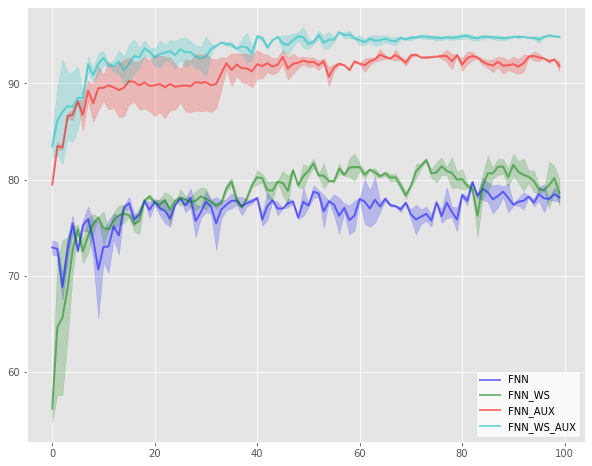

In [38]:
plotacc(histories_mean[:4], histories_std[:4], '#of epochs', 'loss', curve_names[:4])

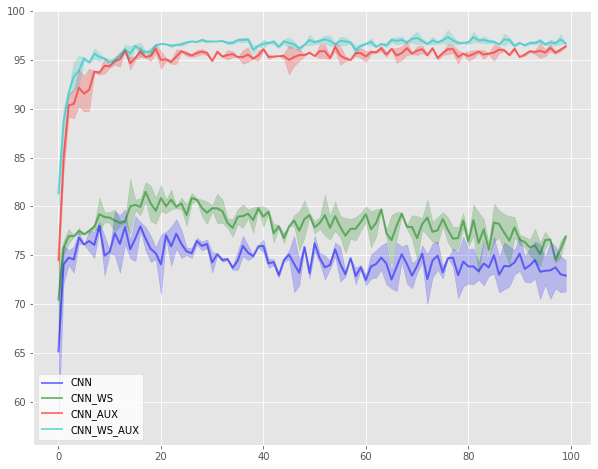

In [40]:
plotacc(histories_mean[4:8], histories_std[4:8], '#of epochs', 'loss', curve_names[4:8])

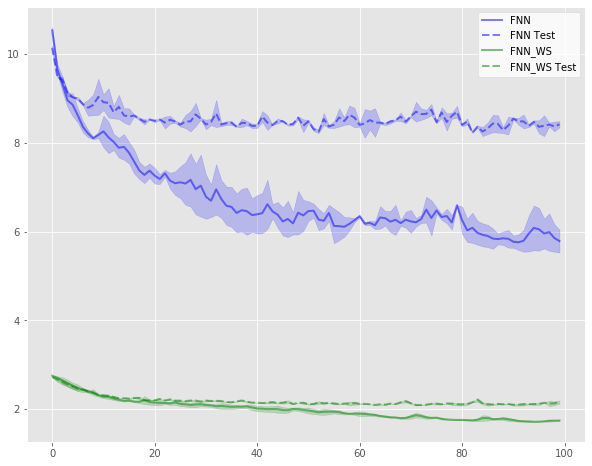

In [41]:
plotLoss(histories_mean[:2], histories_std[:2], '#of epochs', 'loss', curve_names[:2])

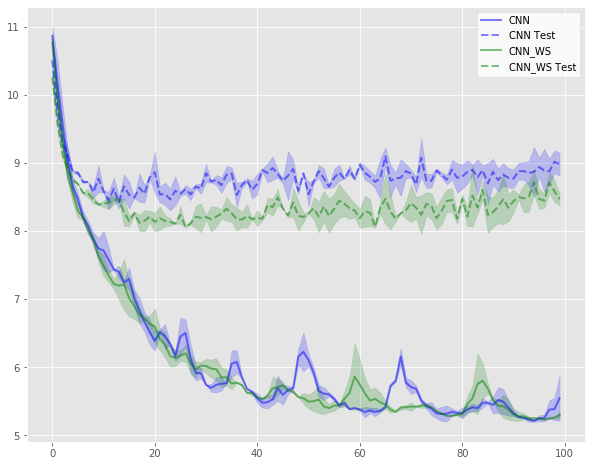

In [42]:
plotLoss(histories_mean[4:6], histories_std[4:6], '#of epochs', 'loss', curve_names[4:6])

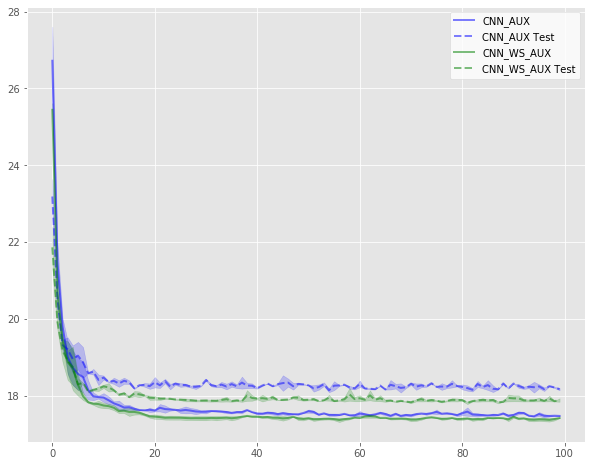

In [25]:
#plotLoss([histories[7]] + [histories[6]], '#of epochs', 'loss',  [curve_names[7]] + [curve_names[6]])
plotLoss(histories_mean[6:8], histories_std[6:8], '#of epochs', 'loss', curve_names[6:8])

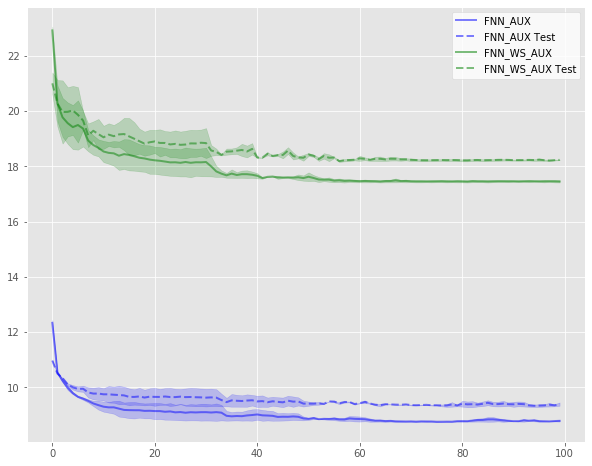

In [43]:
#plotLoss(histories[2:4], '#of epochs', 'loss', curve_names[2:4])
plotLoss(histories_mean[2:4], histories_std[2:4], '#of epochs', 'loss', curve_names[2:4])

In [ ]:
"""# Do 10 runs for each model while saving the histories of the models to plot them
n_training = 10

# Computing losses
histories = []
models_accuracies = []
curve_names = [x['model'].__class__.__name__ for x in initialize_models()]
for i in range(n_training):
    models = initialize_models()
    accuracies = []
    for m in range(len(models)):
        history = train(models[m], train_input1, train_input2, train_classes1,  train_classes2,train_target, \
                        test_input1, test_input2, test_classes1, test_classes2,  test_target)
        acc_target, acc_d1, acc_d2 = compute_nb_errors(models[m]['model'], test_input1, test_input2, test_classes1, test_classes2, test_target)
        #print("\nAccuracy on target = ",acc_target)
        #print("Accuracy on digit 1 = ",acc_d1)
        #print("Accuracy on digit 2 = ",acc_d2)
        accuracies.append(acc_target)
        histories.append(history)
    models_accuracies.append(accuracies)
        
# Computing the mean loss
histories_mean = []
for m in range(len(models)):
    history = histories[m]
    histories_mean.append(history)
# Compute the sum of the losses
for n in range(1,n_training): 
    for m in range(len(models)):
        history = histories[n*8+m]
        histories_mean[m]['train_loss_history'] = [x + y for x, y in \
                                                   zip(histories_mean[m]['train_loss_history'],history['train_loss_history'])]
        histories_mean[m]['test_loss_history'] = [x + y for x, y in \
                                                   zip(histories_mean[m]['test_loss_history'],history['test_loss_history'])]
# Compute the average
for m in range(len(models)):
    histories_mean[m]['train_loss_history'] = [x/10 for x in histories_mean[m]['train_loss_history']]
    histories_mean[m]['test_loss_history'] = [x/10 for x in histories_mean[m]['test_loss_history']]
        
# Printing the mean accuracies
models_accuracies = [list(tup) for tup in zip(*models_accuracies)]
for c in range(len(curve_names)) :
    print("\n", curve_names[c], "Mean Test Accuracies : %.2f" %(sum(models_accuracies[c])/len(models_accuracies[c])))
    
# Printing the mean loss to check the coherence with the accuracies
for c in range(len(curve_names)) :
    print("\n", curve_names[c], "Mean Test loss :", histories_mean[c]['train_loss_history'])        
"""